In [107]:
import cv2
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from numpy import dot
from numpy import linalg as la
from numpy.linalg import norm
import matplotlib
from matplotlib import pyplot as plt
from collections import Counter
import time
import random

In [108]:
#Crearea matricei de antrenare
A = np.zeros([10304,320])
index = 0
pathSursa="/content/drive/MyDrive/Proiecte"

for i in range(1,41):
  pathPersoane = pathSursa +"/s" + str(i) + "/"
  for j in range(1,9):
    pathPozaAntrenare = pathPersoane + str(j) + '.pgm'
    # citim poza ca matrice 112 x 92:
    pozaAntrenare = np.array(cv2.imread(pathPozaAntrenare,0))
    # vectorizam poza:
    pozaVect = pozaAntrenare.reshape(10304,)
    A[:,index] = pozaVect
    index=index+1

In [109]:
#Algoritmul NN

def AlgoritmulNN(A, pozaCautata, norma):
  distante = np.zeros(len(A[0]))

  if(norma == "L1"):
    for i in range(0,len(distante)):
      distante[i] = np.linalg.norm((A[:,i]-pozaCautata), ord=1)

  elif(norma == "L2"):
    for i in range(0,len(distante)):
      distante[i] = la.norm(A[:,i]-pozaCautata)

  elif(norma == "LINF"):
    for i in range(0,len(distante)):
      distante[i] = np.linalg.norm((A[:,i]-pozaCautata), ord=np.inf)

  elif(norma == "LCOS"):
    for i in range(0,len(distante)):
      distante[i] = 1 - np.inner(A[:,i], pozaCautata)/(norm(A[:,i])*norm(pozaCautata))

  else:
    print("Nume norma incorect. Incercati L1, L2, LINF sau LCOS")
    return -1
    

  pozitia = np.argmin(distante) # returneaza indicele la care se afla cea mai mica distanta
  
  return pozitia # pozitia la care se afla imaginea gasita

# **Algoritmul Eigenfaces**

In [110]:
def Eigenfaces(A, pozaCautata, k):
  #Preprocesare
  media = np.mean(A, axis = 1) 
  #B = A # backup

  A = (A.T - media).T

  L = np.dot(A.T, A)

  d, v = np.linalg.eig(L)

  v = np.dot(A, v)


  indici = np.argsort(d) 

  top_k_indici = indici[::-1][:k]

  HQPB = v[:,top_k_indici]


  proiectii = np.dot(A.T, HQPB)
  #A = B # restore

  #Interogare/Cautare
  pozaCautata = pozaCautata - media

  pr_pozaCautata = np.dot(pozaCautata, HQPB)

  rezultat_EIG = AlgoritmulNN(proiectii.T, pr_pozaCautata , "L1")

  return rezultat_EIG

A fost gasita pozitia 39
Rezultat Eigenfaces varianta clasica: Persoana 5 , Poza 8


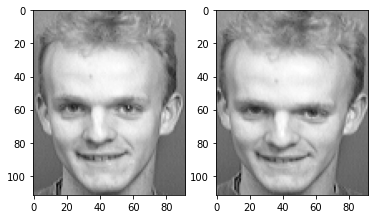

In [111]:
#Afisarea rezultatului 
pozaCautata = (np.array(cv2.imread('/content/drive/MyDrive/Proiecte/s5/9.pgm',0))).reshape(10304,)
pozaCopie = pozaCautata

rezultat_EIG = Eigenfaces(A, pozaCautata ,3)
print("A fost gasita pozitia", rezultat_EIG)
print("Rezultat Eigenfaces varianta clasica: Persoana", rezultat_EIG//8+1, ", Poza", rezultat_EIG%8+1)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(pozaCopie.reshape(112,92), cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(A[:,rezultat_EIG].reshape(112,92), cmap='gray')
plt.show(block=True)

# **Algoritmul Eigenfaces cu reprezentanti de clasa**

In [112]:
def EigenfacesClase(A, pozaCautata, k):
  #Preprocesare
  media = np.mean(A, axis = 1) 

  #Crearea tabloului RC
  RC = np.zeros([10304,40])

  for i in range(0,40):
    poze_persoana = np.zeros([10304, 8])
    for j in range(0,7):
      poze_persoana[:,j] = A[:, i*8 + j]
    reprezentant = np.mean(poze_persoana, axis = 1)
    RC[:,i] = reprezentant
    #RC[:,i] = A[:, i*8 + random.randint(1, 8)]

  RC = (RC.T - media).T

  L = np.dot(RC.T, RC)

  d, v = np.linalg.eig(L)
  v = np.dot(RC, v)


  indici = np.argsort(d) 

  top_k_indici = indici[::-1][:k]

  HQPB = v[:,top_k_indici]

  proiectii = np.dot(RC.T, HQPB)


  #Interogare/Cautare
  pozaCautata = pozaCautata - media

  pr_pozaCautata = np.dot(pozaCautata, HQPB)

  rezultat_EIGC = AlgoritmulNN(proiectii.T, pr_pozaCautata , "L1")

  return rezultat_EIGC

A fost gasita pozitia  17
Rezultat Eigenfaces cu reprezentanti: Persoana 3 , Poza 2


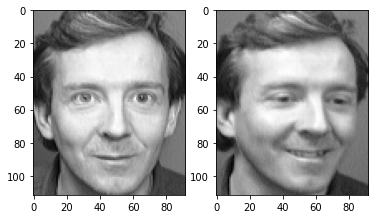

In [113]:
#Afisarea rezultatului
pozaCautata = (np.array(cv2.imread('/content/drive/MyDrive/Proiecte/s3/9.pgm',0))).reshape(10304,)
pozaCopie = pozaCautata

rezultat_EIGC = EigenfacesClase(A, pozaCautata ,3)
print("A fost gasita pozitia ", rezultat_EIGC)
print("Rezultat Eigenfaces cu reprezentanti: Persoana", rezultat_EIGC//8+1, ", Poza", rezultat_EIGC%8+1)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(pozaCopie.reshape(112,92), cmap='gray')
f.add_subplot(1,2, 2)
plt.imshow(A[:,rezultat_EIGC].reshape(112,92), cmap='gray')
plt.show(block=True)

# **Algoritmul Lanczos**

In [153]:
def Lanczos(A, pozaCautata, k):
  m = 10304
  q = np.zeros([m, k+2])
  q[:,0]=np.zeros(m)
  q[:,1]=np.ones(m)
  q[:,1]=q[:,1]/la.norm(q[:,1])

  for i in range(1,k+1):
    w = np.dot(A, np.dot(A.T, q[:,i])) - np.dot(la.norm(q[:,i-1]),q[:,i-1])
    a = np.dot(w, q[:,i])
    w = w - np.dot(a,q[:,i])
    q[:,i+1]=w/la.norm(q[:,i])

  HQPB = q[:,2:]

  proiectii = np.dot(A.T, HQPB)

  pozaCautata = pozaCautata - media

  pr_pozaCautata = np.dot(pozaCautata, HQPB)

  rezultat_Lanczos = AlgoritmulNN(proiectii.T, pr_pozaCautata , "L1")
  return rezultat_Lanczos


A fost gasita pozitia  268
Rezultat Eigenfaces cu reprezentanti: Persoana 34 , Poza 5


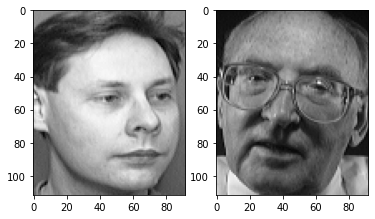

In [154]:
#Afisarea rezultatului
pozaCautata = (np.array(cv2.imread('/content/drive/MyDrive/Proiecte/s4/10.pgm',0))).reshape(10304,)
pozaCopie = pozaCautata

rezultat_Lanczos = Lanczos(A, pozaCautata, 3)


print("A fost gasita pozitia ", rezultat_Lanczos)
print("Rezultat Eigenfaces cu reprezentanti: Persoana", rezultat_Lanczos//8+1, ", Poza", rezultat_Lanczos%8+1)

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(pozaCopie.reshape(112,92), cmap='gray')
f.add_subplot(1, 2, 2)
plt.imshow(A[:,rezultat_Lanczos].reshape(112,92), cmap='gray')
plt.show(block=True)